In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
sys.path.append(os.path.abspath("..")) 
from src.training.train import train_autoencoder, train_cellfate
from sklearn.model_selection import train_test_split
from src.models.classifier import mlp_classifier
import tensorflow as tf
from src.evaluation.evaluate import shapiro_wilk_test, plot_qq_plots
from sklearn.metrics import confusion_matrix
from src.preprocessing.preprocessing_functions import augment_dataset, augmentations

# Splitting data (first frame only)

In [16]:
x_train = np.load('../data/images/train_no_aug_time_norm.npy')[:,0,:,:]  
y_train = np.load('../data/labels/train_labels.npy')  
x_test = np.load('../data/images/test_time_norm.npy')[:,0,:,:]
y_test = np.load('../data/labels/test_labels.npy')

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split

# Combine all your data
x_all = np.concatenate([x_train, x_test], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)

print(f"Combined data shape: {x_all.shape}")
print(f"Combined labels shape: {y_all.shape}")

# First split: 60% train, 40% temp (which will become 20% val + 20% test)
x_train_new, x_temp, y_train_new, y_temp = train_test_split(
    x_all, y_all, 
    test_size=0.4,  # 40% for temp (val + test)
    random_state=42, 
    stratify=y_all  # Keep class balance
)

# Second split: Split the 40% temp into 20% val + 20% test
x_val, x_test_new, y_val, y_test_new = train_test_split(
    x_temp, y_temp,
    test_size=0.5,  # 50% of 40% = 20% of total
    random_state=42,
    stratify=y_temp  # Keep class balance
)

# Verify the splits
total_samples = len(x_all)
print(f"\nSplit verification:")
print(f"Train: {len(x_train_new)} samples ({len(x_train_new)/total_samples*100:.1f}%)")
print(f"Val:   {len(x_val)} samples ({len(x_val)/total_samples*100:.1f}%)")
print(f"Test:  {len(x_test_new)} samples ({len(x_test_new)/total_samples*100:.1f}%)")

# Check class balance in each split
print(f"\nClass distribution:")
print(f"Train - Class 0: {np.sum(y_train_new == 0)}, Class 1: {np.sum(y_train_new == 1)}")
print(f"Val   - Class 0: {np.sum(y_val == 0)}, Class 1: {np.sum(y_val == 1)}")
print(f"Test  - Class 0: {np.sum(y_test_new == 0)}, Class 1: {np.sum(y_test_new == 1)}")


Combined data shape: (1385, 20, 20)
Combined labels shape: (1385,)

Split verification:
Train: 831 samples (60.0%)
Val:   277 samples (20.0%)
Test:  277 samples (20.0%)

Class distribution:
Train - Class 0: 694, Class 1: 137
Val   - Class 0: 231, Class 1: 46
Test  - Class 0: 232, Class 1: 45


In [22]:
augmented_x_train, augmented_y_train = augment_dataset(
                x_train_new, 
                y_train_new, 
                augmentations, 
                augment_times=5,
                seed=42
            )

Balancing Class 0: 4164 → 822 samples (preserving augmentation structure)
✅ Balanced Class 0: 822 samples with equal augmentation representation


In [25]:
# np.save('../data/final_split/x_train.npy', x_train_new)
# np.save('../data/final_split/y_train.npy', y_train_new)
# np.save('../data/final_split/x_val.npy', x_val)
# np.save('../data/final_split/y_val.npy', y_val)
# np.save('../data/final_split/x_test.npy', x_test_new)
# np.save('../data/final_split/y_test.npy', y_test_new)
# np.save('../data/final_split/augmented_x_train.npy', augmented_x_train)
# np.save('../data/final_split/augmented_y_train.npy', augmented_y_train)

In [28]:
x_train_new.shape

(831, 20, 20)

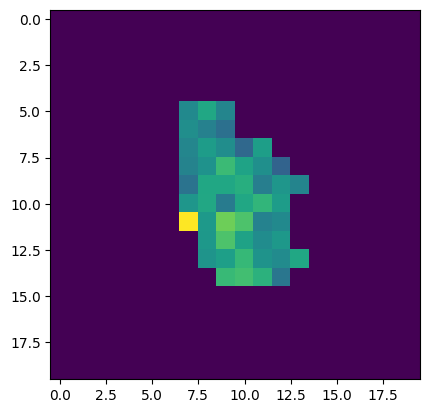

In [23]:
plt.imshow(augmented_x_train[1])

# Load augmented data

In [3]:
x_train = np.load('../data/final_split/augmented_x_train.npy')
y_train = np.load('../data/final_split/augmented_y_train.npy')
x_val = np.load('../data/final_split/x_val.npy')
y_val = np.load('../data/final_split/y_val.npy')
x_test = np.load('../data/final_split/x_test.npy')
y_test = np.load('../data/final_split/y_test.npy')

In [2]:
second_gen_images = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/second_generation/stretched_second_gen.npy')
second_gen_labels = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/second_generation/second_gen_labels.npy')

combined_images = second_gen_images
combined_labels = second_gen_labels

# Combine first and second generation data
#combined_images = np.concatenate([first_gen_images, second_gen_images], axis=0)
#combined_labels = np.concatenate([first_gen_labels, second_gen_labels], axis=0)

print(f"Combined dataset shape: {combined_images.shape}")
print(f"Combined labels shape: {combined_labels.shape}")
print(f"Label distribution: {np.bincount(combined_labels)}")

# First split: 60% train, 40% temp (which will be split into 20% val, 20% test)
x_train, x_temp, y_train, y_temp = train_test_split(
    combined_images, combined_labels,
    test_size=0.4,  # 40% for temp (val + test)
    random_state=42,
    stratify=combined_labels  # Keep class balance
)

# Second split: Split the temp 40% into 20% val and 20% test (50/50 split of temp)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp,
    test_size=0.5,  # 50% of 40% = 20% of total for test, 20% for val
    random_state=42,
    stratify=y_temp  # Keep class balance
)

print(f"Train set: {x_train.shape[0]} samples ({x_train.shape[0]/len(combined_images)*100:.1f}%)")
print(f"Val set: {x_val.shape[0]} samples ({x_val.shape[0]/len(combined_images)*100:.1f}%)")
print(f"Test set: {x_test.shape[0]} samples ({x_test.shape[0]/len(combined_images)*100:.1f}%)")

# Augment only the training set
augmented_x_train, augmented_y_train = augment_dataset(x_train, y_train, augmentations)

Combined dataset shape: (402, 20, 20)
Combined labels shape: (402,)
Label distribution: [283 119]
Train set: 241 samples (60.0%)
Val set: 80 samples (19.9%)
Test set: 81 samples (20.1%)
Balancing Class 0: 1020 → 426 samples (preserving augmentation structure)
✅ Balanced Class 0: 426 samples with equal augmentation representation


# Load Pretrained AI4CellFate Model

In [3]:
### Second generation

x_train = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/data/second_generation/augmented_x_traintrain_second_gen.npy")
y_train = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/data/second_generation/augmented_y_train_second_gen.npy")

In [4]:
from src.models import Encoder, Decoder, Discriminator, mlp_classifier

config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
    'latent_dim': 2,
    'GaussianNoise_std': 0.003,
    'lambda_recon': 5, 
    'lambda_adv': 0.05,
    'lambda_clf': 0.05,
    'lambda_cov': 0.1,
}

img_shape = (x_train.shape[1], x_train.shape[2], 1)
encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
discriminator = Discriminator(latent_dim=config['latent_dim']).model

encoder.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/second_gen_s1_ep35_lr5_la1_seed42_ldim2_s2_lr6_la4_lc1_lcon14/models/encoder.weights.h5") ###TODO: change to the model path
decoder.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/second_gen_s1_ep35_lr5_la1_seed42_ldim2_s2_lr6_la4_lc1_lcon14/models/decoder.weights.h5") ###TODO: change to the model path
discriminator.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/models/autoencoder_cov/discriminator.weights.h5") ###TODO: change to the model path

/Users/inescunha/anaconda3/envs/testcellfate/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/testcellfate/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


## OPTIONAL: Train AI4CellFate from scratch

Stage 1: Train Adversarial Autoencoder for a low number of epochs, to wait for the reconstruction losses to converge before we do any latent space engineering

In [4]:
config_autoencoder = {
        'batch_size': 30,
        'epochs': 15,
        'learning_rate': 0.001,
        'seed': 42,
        'latent_dim': 2,
        'GaussianNoise_std': 0.003,
        'lambda_recon': 5,
        'lambda_adv': 1,
    }

lambda_autoencoder_results = train_autoencoder(config_autoencoder, x_train)
encoder = lambda_autoencoder_results['encoder']
decoder = lambda_autoencoder_results['decoder']
discriminator = lambda_autoencoder_results['discriminator']

Training with batch size: 30, epochs: 15, learning rate: 0.001, seed: 42, latent dim: 2


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.2867, Adversarial loss: 0.7489, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.7749, Adversarial loss: 0.7269, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7638, Adversarial loss: 0.7135, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7467, Adversarial loss: 0.7116, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7450, Adversarial loss: 0.7094, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7531, Adversarial loss: 0.6986, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7237, Adversarial loss: 0.7067, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7281, Adversarial loss: 0.7037, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7274, Adversarial loss: 0.6983, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Stage 2: Train full AI4CellFate model (using the trained AAE from stage 1), where we add contrastive and covariance losses to enforce the latent features to be optimised for the classification task and independent from each other (for interpretation)

In [ ]:
config_ai4cellfate = {
        'batch_size': 30,
        'epochs': 100,
        'learning_rate': 0.001,
        'seed': 42,
        'latent_dim': 2,
        'GaussianNoise_std': 0.003,
        'lambda_recon': 6,
        'lambda_adv': 4,
        'lambda_cov': 0.0001,
        'lambda_contra': 8,
    }
 
lambda_ae_cov_results = train_cellfate(config_ai4cellfate, encoder, decoder, discriminator, x_train, y_train, x_test, y_test) 
encoder = lambda_ae_cov_results['encoder']
decoder = lambda_ae_cov_results['decoder']
discriminator = lambda_ae_cov_results['discriminator']

# Visualise Latent Space

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


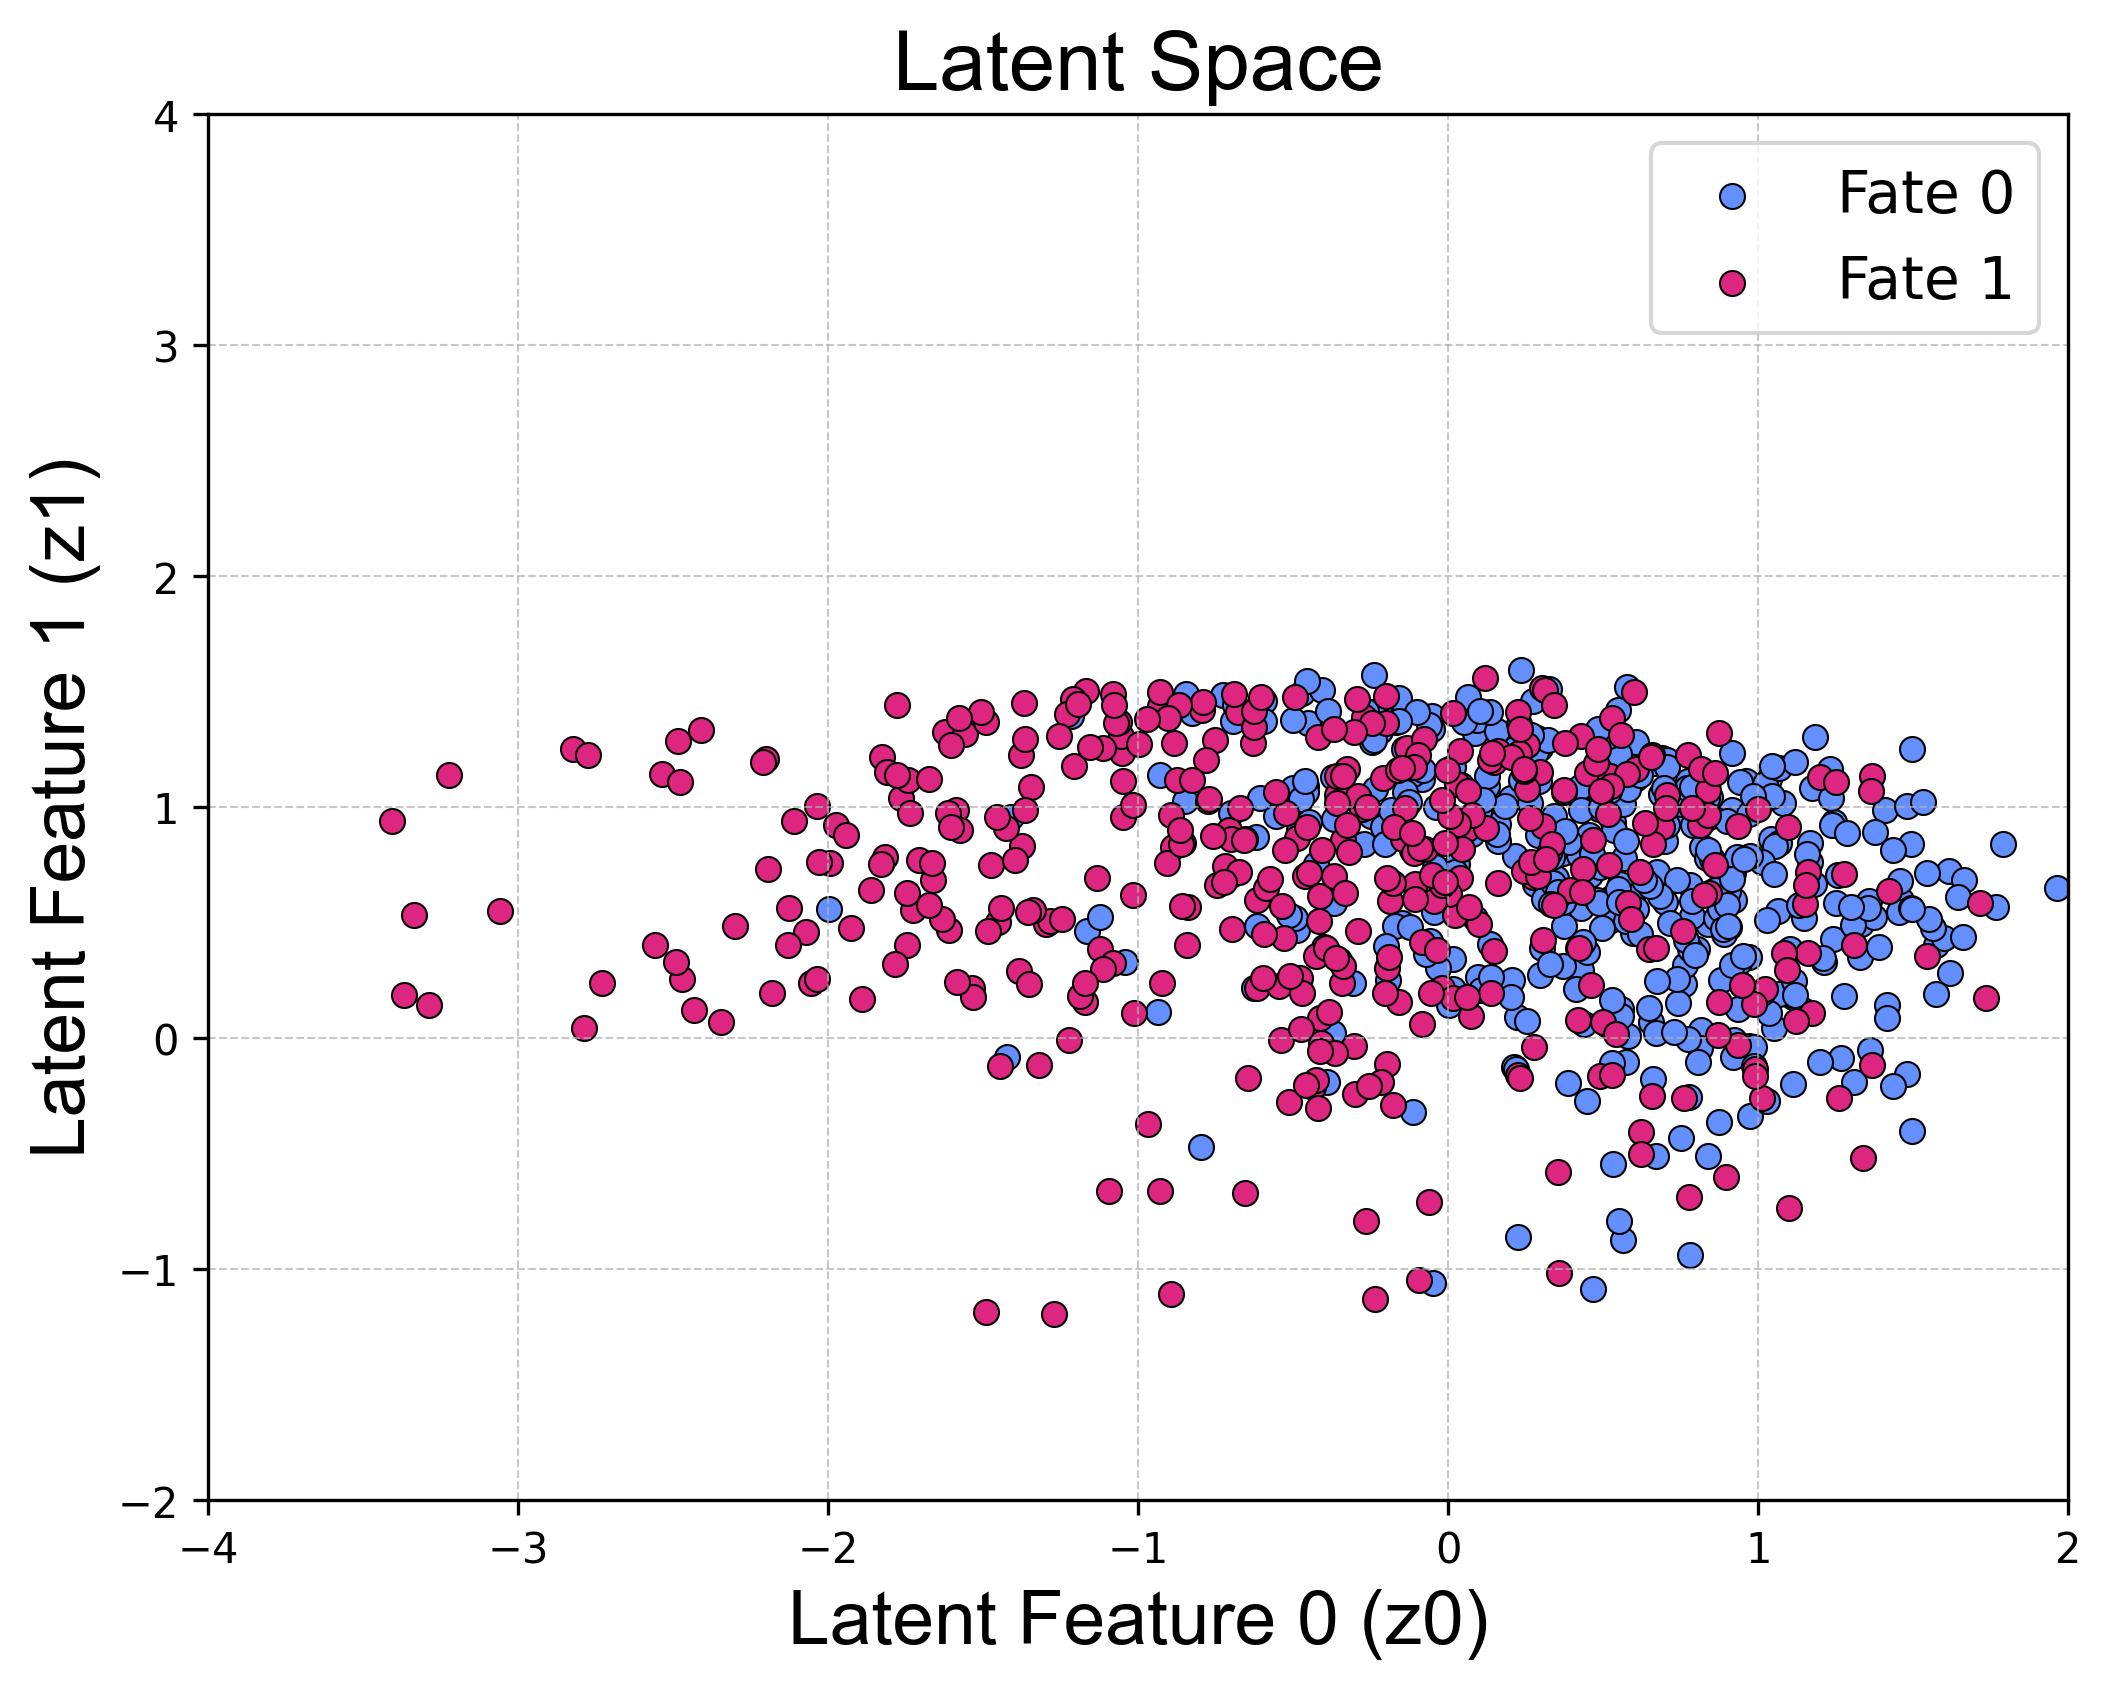

In [11]:
# Predict the latent representations
latent_2d = encoder.predict(augmented_x_train) 

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately with thin gray edges
plt.scatter(latent_2d[augmented_y_train == 0][:, 0], latent_2d[augmented_y_train == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  
plt.scatter(latent_2d[augmented_y_train == 1][:, 0], latent_2d[augmented_y_train == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  

# Set axis limits
plt.xlim(-4, 2)
plt.ylim(-2, 4)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")

# Legend and grid
plt.legend(fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

#plt.savefig("rasterised_ls_cellfate.eps", dpi=600, bbox_inches="tight")
plt.show()

## Visualise Test Latent Space

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


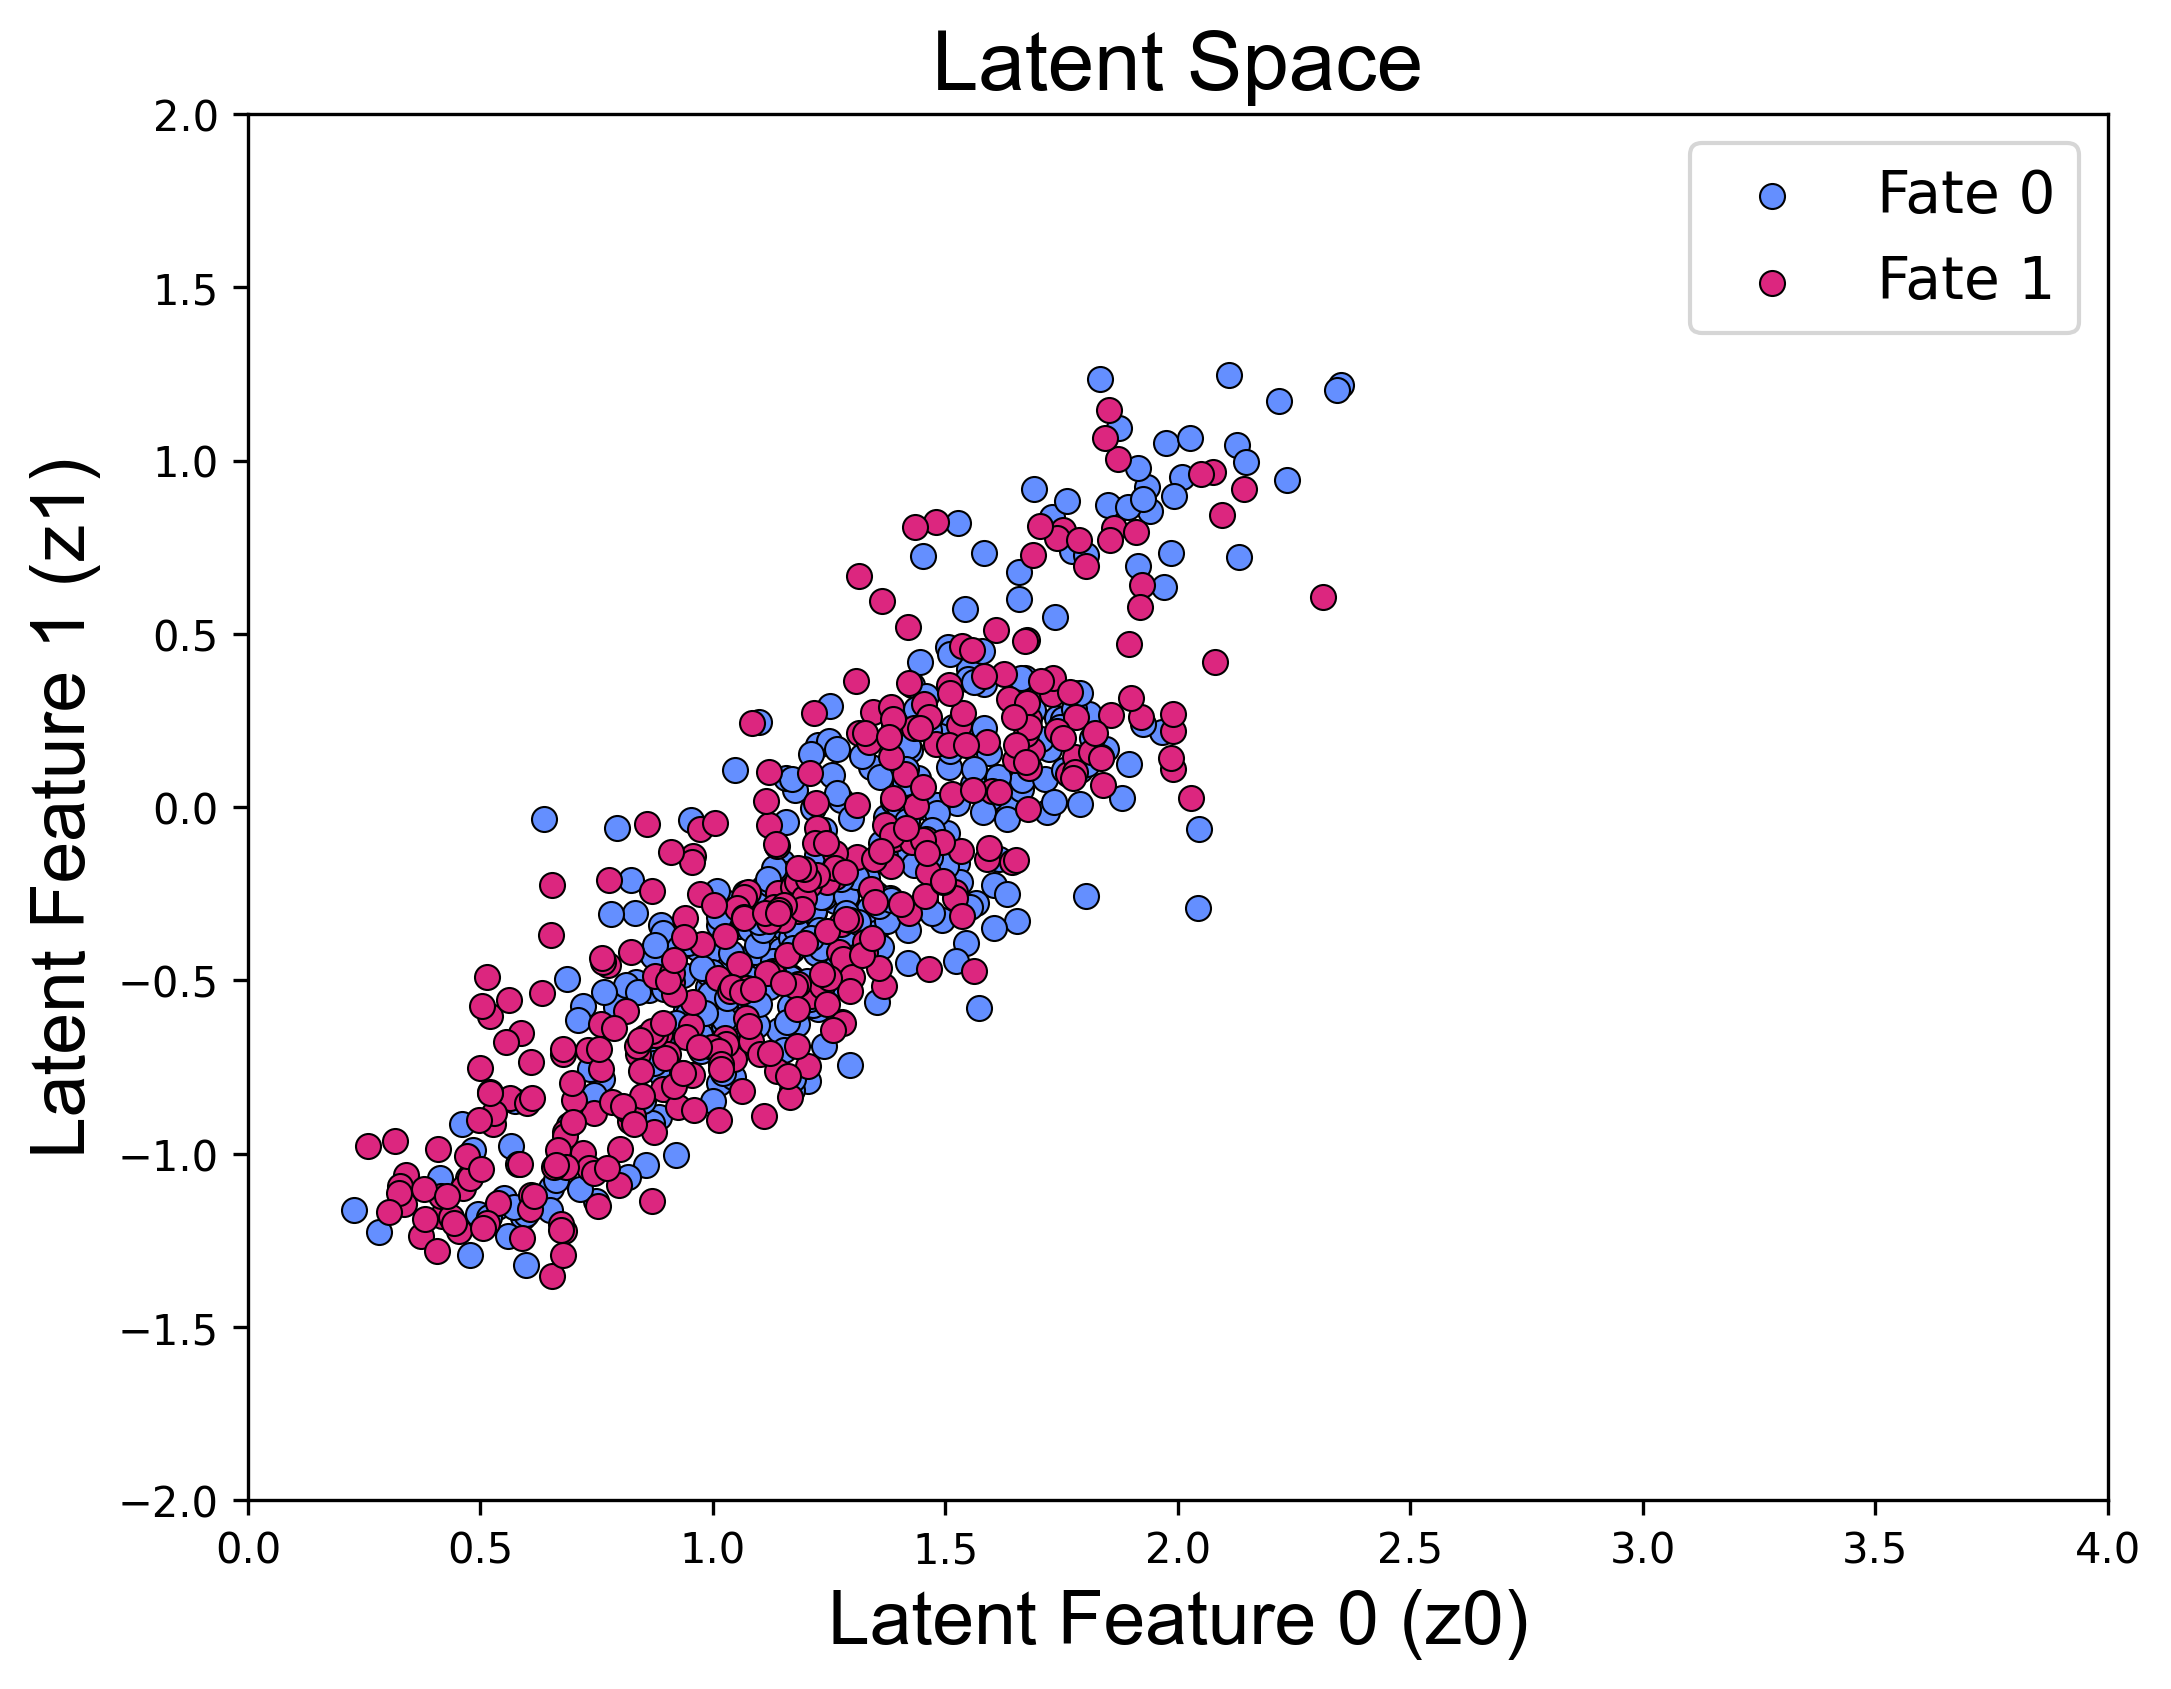

In [ ]:
# Predict the latent representations
x_test = np.load('../data/second_generation/x_test_second_gen.npy')
y_test = np.load('../data/second_generation/y_test_second_gen.npy')
latent_2d = encoder.predict(x_test)  # Shape (1380, 2)

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately with thin gray edges
plt.scatter(latent_2d[y_test == 0][:, 0], latent_2d[y_test == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  
plt.scatter(latent_2d[y_test == 1][:, 0], latent_2d[y_test == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  

# Set axis limits
plt.xlim(-3, 4)
plt.ylim(-3.5, 2)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")

# Legend and grid
plt.legend(fontsize=14)
#plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

#plt.savefig("test_cellfate_noaug_rasterised.eps", dpi=600, bbox_inches="tight")
plt.show()


In [10]:
from scipy.spatial.distance import euclidean
# Compute centroids
centroid_class_0 = np.mean(encoder.predict(x_test)[y_test == 0], axis=0)
centroid_class_1 = np.mean(encoder.predict(x_test)[y_test == 1], axis=0)

# Compute Euclidean distance between centroids
distance = euclidean(centroid_class_0, centroid_class_1)
print(f"Distance between class centroids: {distance:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Distance between class centroids: 0.5725


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


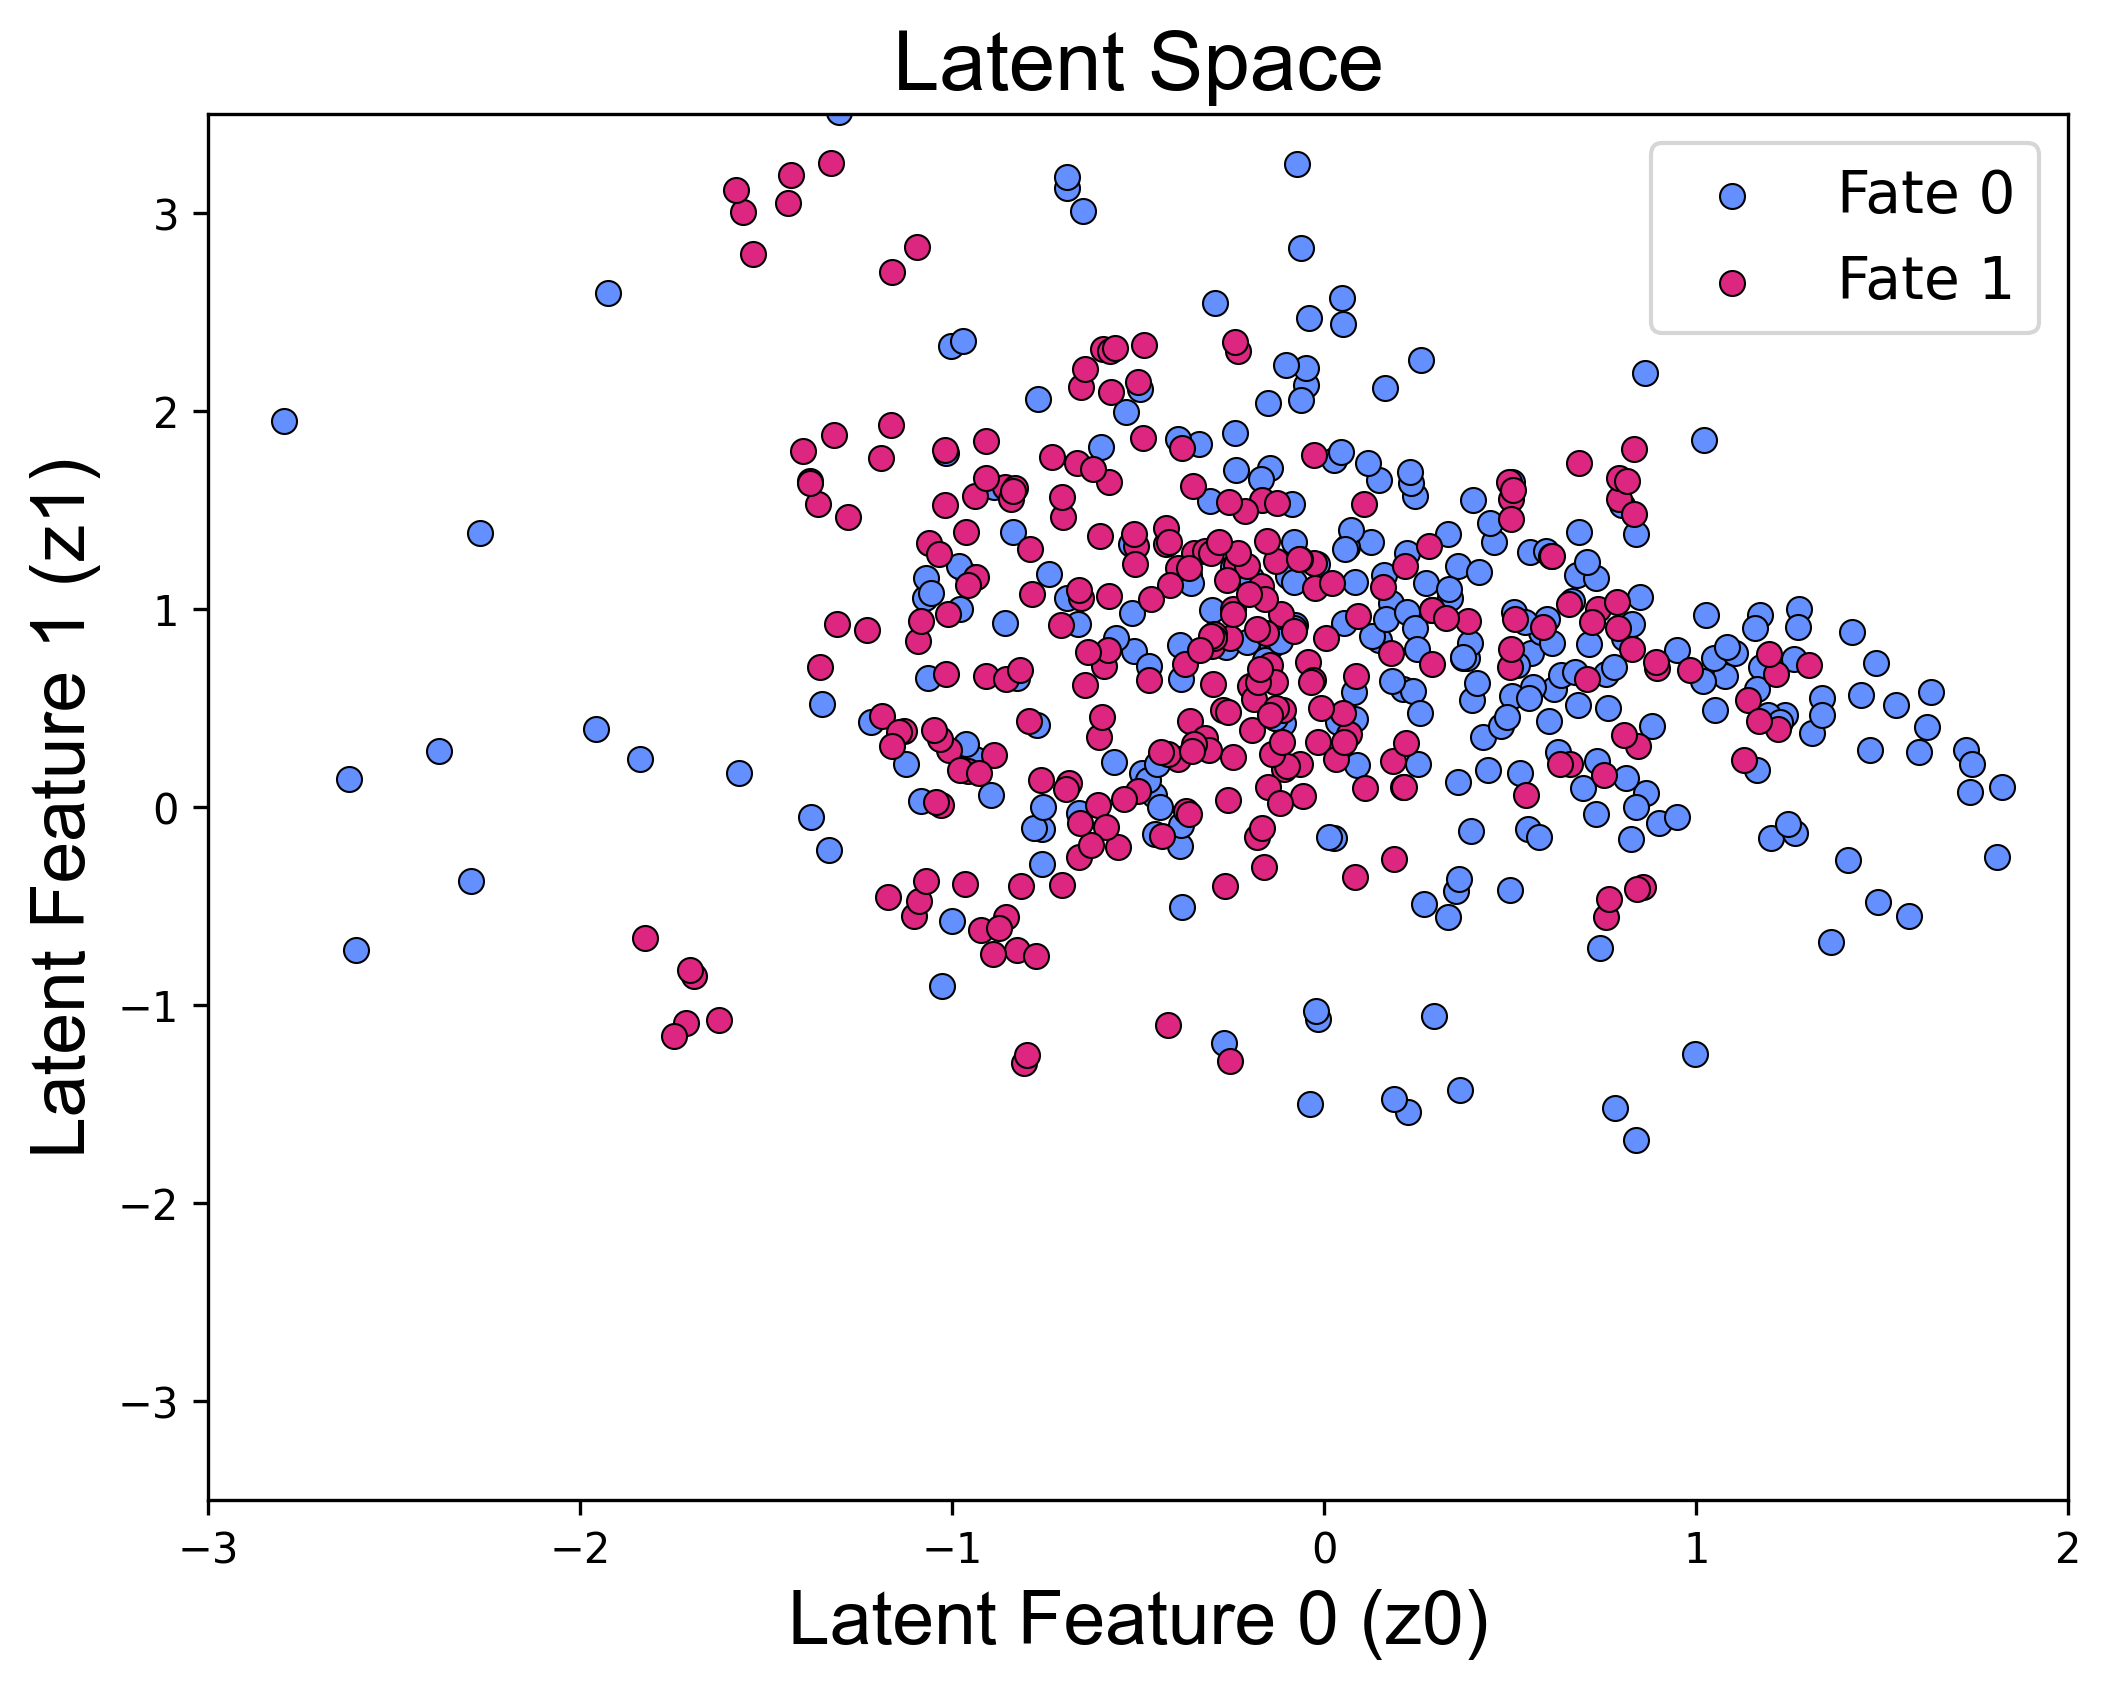

In [11]:
#### latent space correctly saved
from src.preprocessing.preprocessing_functions import *

augmented_x_test_for_visuals, augmented_y_test_for_visuals = augment_dataset(x_test, y_test, augmentations)

# Predict the latent representations
latent_2d = encoder.predict(augmented_x_test_for_visuals)  # Shape (1380, 2)

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately with thin gray edges
plt.scatter(latent_2d[augmented_y_test_for_visuals == 0][:, 0], latent_2d[augmented_y_test_for_visuals == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  
plt.scatter(latent_2d[augmented_y_test_for_visuals == 1][:, 0], latent_2d[augmented_y_test_for_visuals == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  

# Set axis limits
plt.xlim(-3, 2)
plt.ylim(-3.5, 3.5)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")

# Legend and grid
plt.legend(fontsize=14)
#plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

#plt.savefig("test_cellfate_aug_rasterised.eps", dpi=600, bbox_inches="tight")
plt.show()


In [12]:
from scipy.spatial.distance import euclidean
# Compute centroids
centroid_class_0 = np.mean(encoder.predict(augmented_x_test_for_visuals)[augmented_y_test_for_visuals == 0], axis=0)
centroid_class_1 = np.mean(encoder.predict(augmented_x_test_for_visuals)[augmented_y_test_for_visuals == 1], axis=0)

# Compute Euclidean distance between centroids
distance = euclidean(centroid_class_0, centroid_class_1)
print(f"Distance between class centroids: {distance:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
Distance between class centroids: 0.4917


# Classify from Engineered Latent Space

In [18]:
config_clf = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
    'latent_dim': 2,
    'GaussianNoise_std': 0.003,
    'lambda_recon': 5, 
    'lambda_adv': 0.05,
    'lambda_clf': 0.05,
    'lambda_cov': 0.1,
}

tf.keras.utils.set_random_seed(config_clf['seed'])

classifier = mlp_classifier(latent_dim=config_clf['latent_dim']) #[:, [3, 8]] 

# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_clf['learning_rate']), metrics=['accuracy'])
classifier.summary()

history = classifier.fit(encoder.predict(augmented_x_train), augmented_y_train, batch_size=config_clf['batch_size'], epochs=config_clf['epochs'], validation_data=(encoder.predict(x_val), y_val)) 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_6 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6522 - loss: 0.5924 - val_accuracy: 0.6375 - val_loss: 0.7826
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.6532 - loss: 0.5957 - val_accuracy: 0.6375 - val_loss: 0.7828
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.6763 - loss: 0.5786 - val_accuracy: 0.6375 - val_loss: 0.7830
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.6205 - loss: 0.6114 - val_accuracy: 0.6250 - val_loss: 0.7795
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.6409 - loss: 0.5987 - val_accuracy: 0.6000 - val_loss: 0.7776
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.6444 - loss: 0.5764 - val_accuracy: 0.6000 - val_loss: 0.7763
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.6696 - loss: 0.5737 - val_accuracy: 0.6000 - val_loss: 0.7756
Epoch 8/50
29/29 ━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[[0.77192982 0.22807018]
 [0.41666667 0.58333333]]


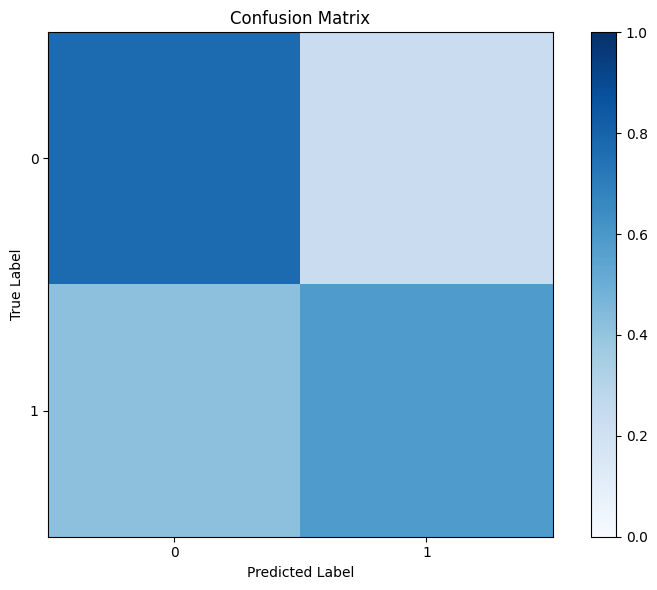

In [19]:
num_classes = len(np.unique(y_train))
y_pred = classifier.predict(encoder.predict(x_test))
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [6]:
encoder.predict(x_train).shape

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


(1644, 2)

# Visual Interpretation 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


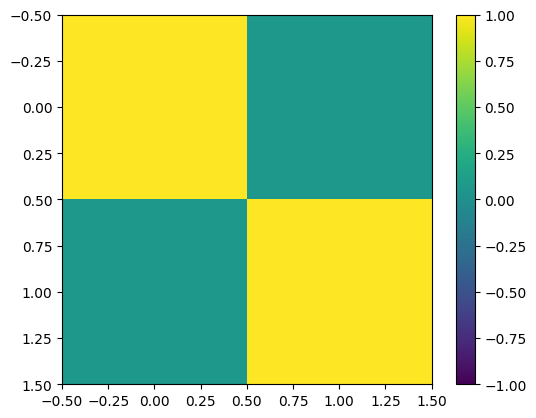

In [5]:
correlation = np.corrcoef(encoder.predict(x_train)[:,0], encoder.predict(x_train)[:,1])
plt.imshow(correlation, vmin=-1, vmax=1)
plt.colorbar()

(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


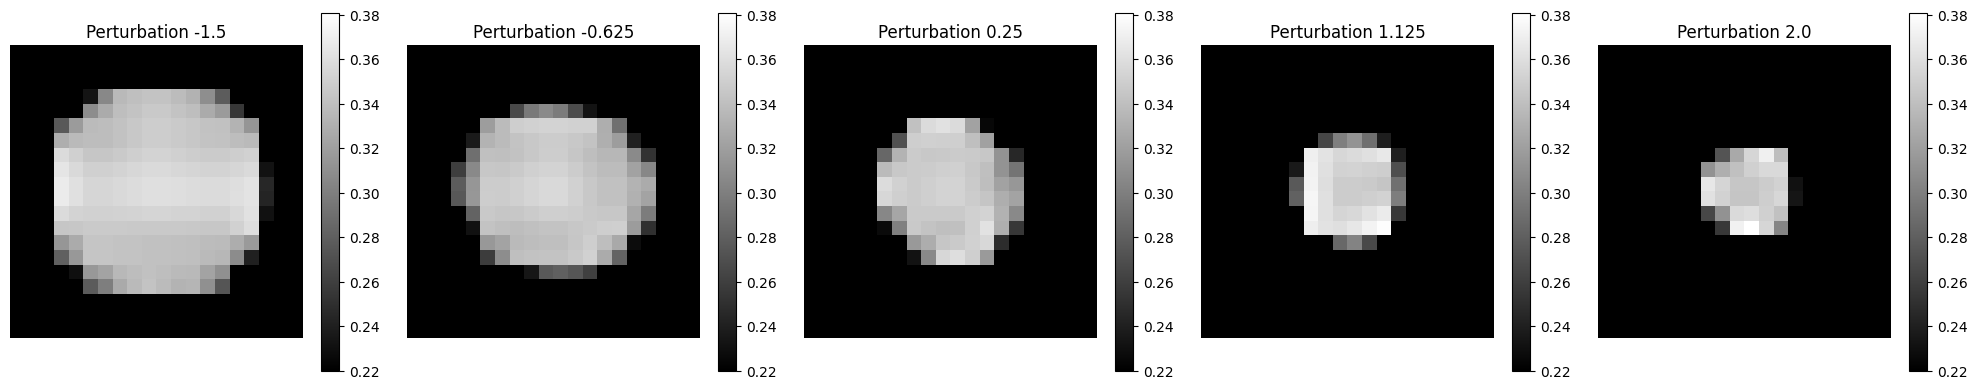

In [5]:
baseline_latent_vector = np.zeros((2, 2), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 1

# Perturbation range
perturbations = np.linspace(-1.5, 2, 5) # feature index 1
#perturbations = np.linspace(-2.5, 1.5, 5) # feature index 0

# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(5):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=0.22, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
#plt.savefig("perturbations_feat1.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


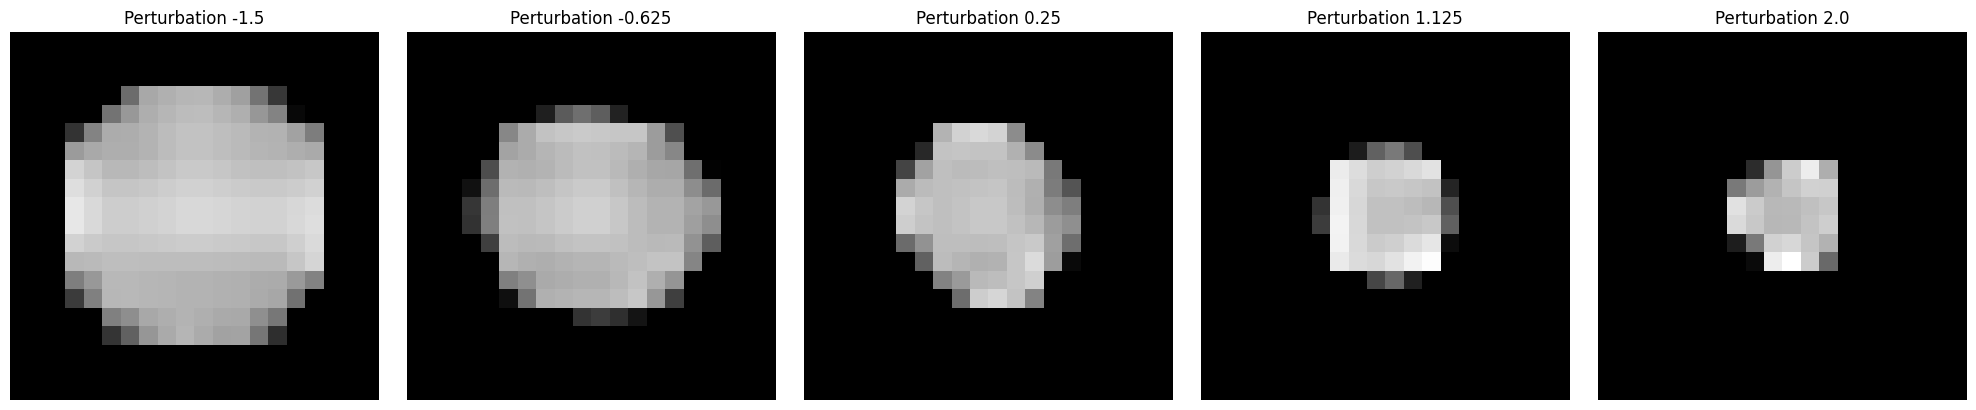

In [ ]:
baseline_latent_vector = np.zeros((2, 2), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 1

# Perturbation range
perturbations = np.linspace(-1.5, 2, 5) # feature index 1
#perturbations = np.linspace(-2.5, 1.5, 5) # feature index 0

# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(5):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=0.25, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')

#fig.colorbar(im, ax=axs[i])

plt.tight_layout()
#plt.savefig("second_generation_perturbations_feat1.eps", format="eps", dpi=300, bbox_inches="tight")
plt.show()


(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


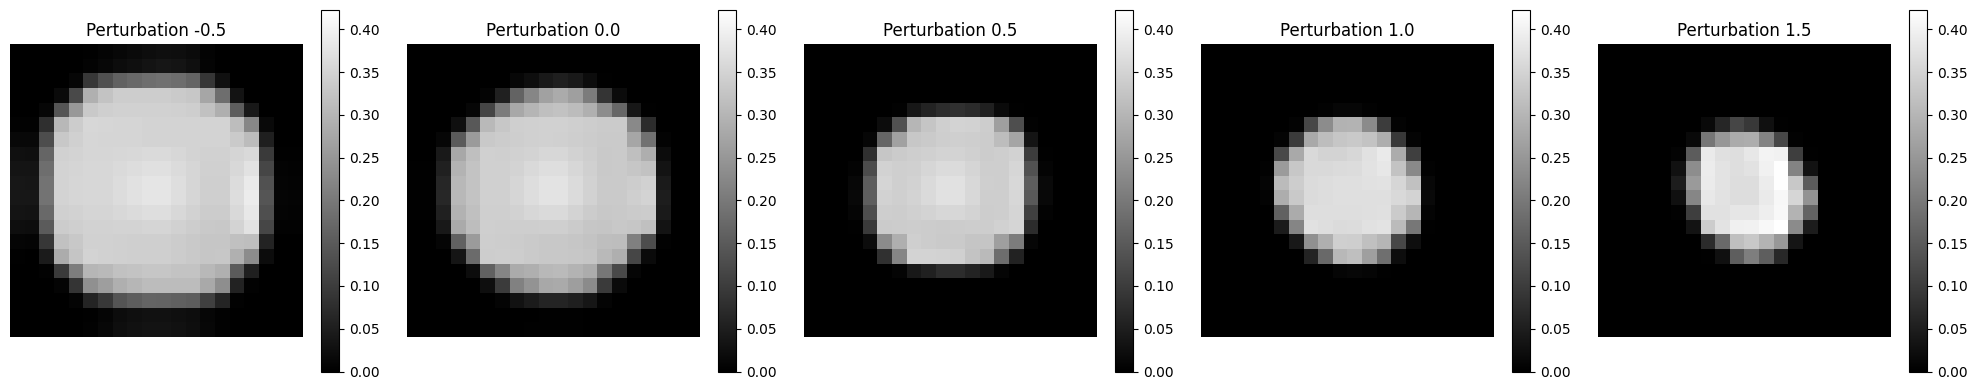

In [6]:
baseline_latent_vector = np.zeros((2, 2), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 1

# Perturbation range
perturbations = np.linspace(-0.5, 1.5, 5) # feature index 1
#perturbations = np.linspace(-2.5, 1.5, 5) # feature index 0

# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(5):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=0.0, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
#plt.savefig("perturbations_feat1.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


### Feature Extraction on the Perturbed Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


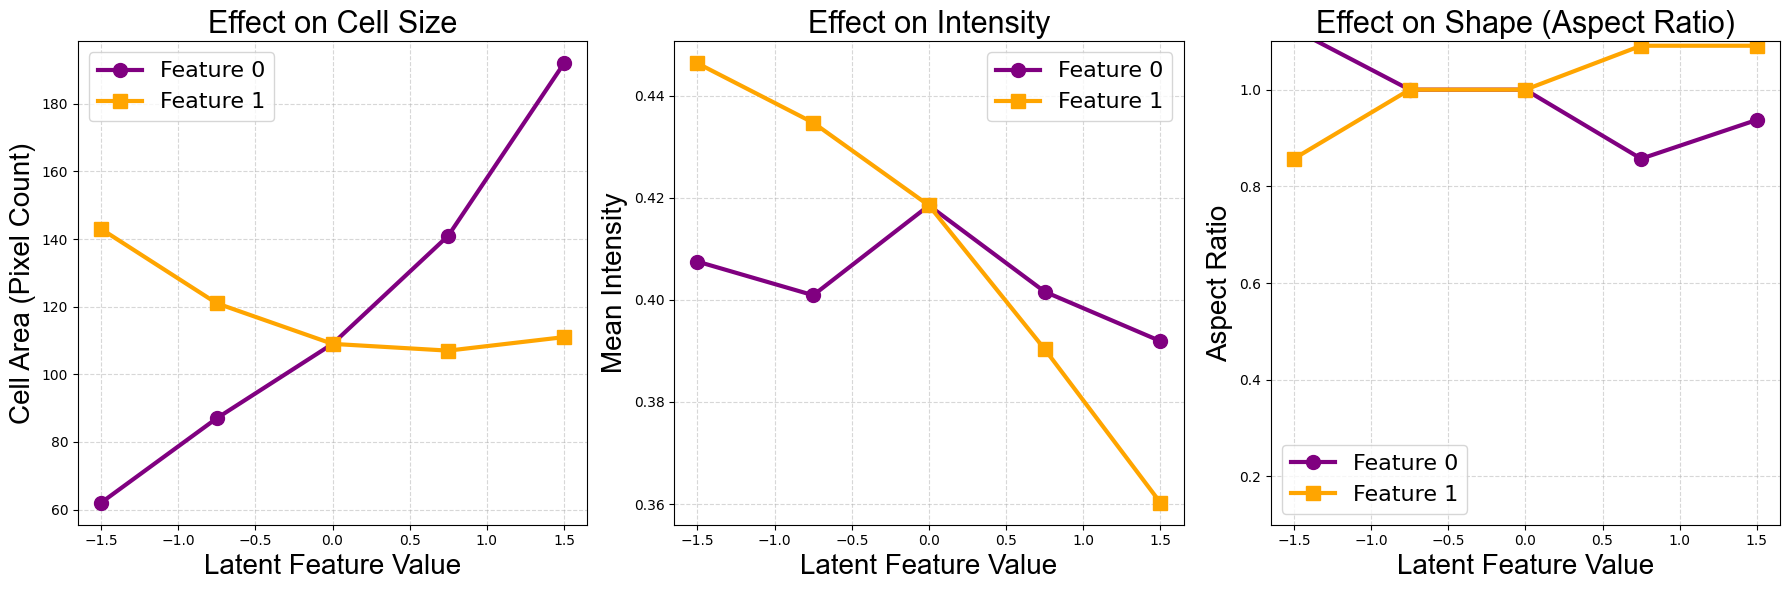

In [10]:
import cv2

# Initialize arrays to store feature effects
areas_0, areas_1 = [], []
intensities_0, intensities_1 = [], []
aspect_ratios_0, aspect_ratios_1 = [], []
circularities_0, circularities_1 = [], []

# Function to compute cell area
def compute_area(image, threshold=0.1):
    return np.sum(image > threshold)

# Function to compute mean intensity
def compute_intensity(image):
    return np.max(image)

# Function to compute shape descriptors (aspect ratio, circularity)
def compute_shape_features(image, threshold=0.1):
    binary = (image > threshold).astype(np.uint8)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return 0, 0  
    
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / h
    
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    circularity = 4 * np.pi * (area / (perimeter ** 2 + 1e-6))  # Avoid division by zero
    
    return aspect_ratio, circularity

# Perturbation values
perturbations = np.linspace(-1.5, 1.5, 5)

# Iterate over both latent features
for feature_index in [0, 1]:
    for value in perturbations:
        # Create perturbed latent vector
        perturbed_vector = np.zeros((2, 2), dtype=np.float32)
        perturbed_vector[0, feature_index] = value

        # Decode the perturbed vector to generate a synthetic image
        synthetic_image = decoder.predict(perturbed_vector)[0, :, :, 0]

        # Compute features
        area = compute_area(synthetic_image)
        intensity = compute_intensity(synthetic_image)
        aspect_ratio, circularity = compute_shape_features(synthetic_image)

        # Store results based on the feature being perturbed
        if feature_index == 0:
            areas_0.append(area)
            intensities_0.append(intensity)
            aspect_ratios_0.append(aspect_ratio)
            circularities_0.append(circularity)
        else:
            areas_1.append(area)
            intensities_1.append(intensity)
            aspect_ratios_1.append(aspect_ratio)
            circularities_1.append(circularity)

# Define colors
# color_0 = "#E69F00"  # Orange
# color_1 = "#009E73"  # Teal
color_0 = "purple"
color_1 = "orange"

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Cell Area
axs[0].plot(perturbations, areas_0, marker='o', color=color_0, markersize=10, linewidth=3, label="Feature 0")
axs[0].plot(perturbations, areas_1, marker='s', color=color_1, markersize=10, linewidth=3, label="Feature 1")
axs[0].set_xlabel("Latent Feature Value", fontsize=20, fontname="Arial")
axs[0].set_ylabel("Cell Area (Pixel Count)", fontsize=20, fontname="Arial")
axs[0].set_title("Effect on Cell Size", fontsize=22, fontname="Arial")
axs[0].legend(fontsize=16)
axs[0].grid(True, linestyle="--", alpha=0.5)

# Plot Mean Intensity
axs[1].plot(perturbations, intensities_0, marker='o', color=color_0, markersize=10, linewidth=3, label="Feature 0")
axs[1].plot(perturbations, intensities_1, marker='s', color=color_1, markersize=10, linewidth=3, label="Feature 1")
axs[1].set_xlabel("Latent Feature Value", fontsize=20, fontname="Arial")
axs[1].set_ylabel("Mean Intensity", fontsize=20, fontname="Arial")
axs[1].set_title("Effect on Intensity", fontsize=22, fontname="Arial")
axs[1].legend(fontsize=16)
axs[1].grid(True, linestyle="--", alpha=0.5)

# Plot Shape Descriptors (Aspect Ratio)
axs[2].plot(perturbations, aspect_ratios_0, marker='o', color=color_0, markersize=10, linewidth=3, label="Feature 0")
axs[2].plot(perturbations, aspect_ratios_1, marker='s', color=color_1, markersize=10, linewidth=3, label="Feature 1")
axs[2].set_xlabel("Latent Feature Value", fontsize=20, fontname="Arial")
axs[2].set_ylabel("Aspect Ratio", fontsize=20, fontname="Arial")
axs[2].set_title("Effect on Shape (Aspect Ratio)", fontsize=22, fontname="Arial")
axs[2].set_ylim(0.1, 1.1)
axs[2].legend(fontsize=16)
axs[2].grid(True, linestyle="--", alpha=0.5)

# Adjust layout and save as high-quality images
plt.tight_layout()
#plt.savefig("feature_effects.eps", format="eps", bbox_inches="tight")

plt.show()
